In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import joblib
import os
from time import time

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier

In [2]:
# Load data
x_tr_resample = pd.read_csv('../../Data/fix/X_train_smote.csv')
y_tr_resample = np.loadtxt("../../Data/fix/y_train_smote.csv", delimiter=",")

In [3]:
# Define Normalisasi
minmax = MinMaxScaler()
x_minmax_scaled = minmax.fit_transform(x_tr_resample)
joblib.dump(minmax, "../../Models/tuning/minmax.pkl")

pt = PowerTransformer()
x_pt_scaled = pt.fit_transform(x_tr_resample)
joblib.dump(pt, "../../Models/tuning/powertransformer.pkl")

['../../Models/tuning/powertransformer.pkl']

In [4]:
# Define hyperparameter grids
param_grids = {
    "LGBM": {
        'n_estimators': [100, 300],
        'learning_rate': [0.3],
        'num_leaves': [120],
        'max_depth': [3],
        'feature_fraction': [0.84],
        'bagging_fraction': [0.75],
        'min_data_in_leaf': [80],
        'lambda_l1': [0.2],
        'lambda_l2': [0.56]
    },
    "ETC": {
        'n_estimators': [400],
        'max_depth': [50],
        'min_samples_split': [2],
        'min_samples_leaf': [2],
        'max_features': [None],
        'bootstrap': [True],
        'criterion': ['gini']
    },
    "SVM": {
        'C': [1000],
        'gamma': [10],
        'kernel': ['rbf']
    },
    "GNB": {
        'var_smoothing': np.concatenate([
            np.logspace(-15, -12, 10),
            np.logspace(-12, -9, 15),
            np.logspace(-9, -6, 15),
            np.logspace(-6, -3, 10)
        ]),
        'priors': [
            None,
            [0.05, 0.95], [0.95, 0.05],
            [0.1, 0.9], [0.15, 0.85],
            [0.3, 0.7], [0.35, 0.65],
            [0.4, 0.6], [0.45, 0.55],
            [0.5, 0.5],
            [0.55, 0.45], [0.6, 0.4],
            [0.65, 0.35], [0.7, 0.3],
            [0.75, 0.25], [0.8, 0.2], [0.85, 0.15],
            [0.9, 0.1], [0.95, 0.05]
        ],
    },
    "CATBOOST": {
        'iterations': [100, 300],
        'depth': [8, 10],
        'learning_rate': [0.05, 0.1]
    }
}

In [5]:
# Define models
models = {
    "LGBM": LGBMClassifier(boosting_type='gbdt', objective='binary', metric='accuracy', verbose=-1, random_state=42),
    "ETC": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "GNB": GaussianNB(),
    "CATBOOST": CatBoostClassifier(random_state=42, devices='0:1', logging_level='Silent', allow_writing_files=False)
}

In [6]:
# Directory untuk menyimpan model
model_dir = "../../Models/Tuning/"
os.makedirs(model_dir, exist_ok=True)

In [7]:
# Training loop
training_results = []
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_results = {}  # Untuk menyimpan hasil GridSearchCV semua model
cv_scores = {}  # Untuk menyimpan skor CV parameter terbaik
computation_times = {}  # Untuk menyimpan waktu komputasi setiap model

for name, model in models.items():
    print(f"\n🔍 Tuning {name} with GridSearchCV...", flush=True)
    start_time = time()

    # Select dataset
    if name == "SVM":
        X_train = x_minmax_scaled
    elif name == "GNB":
        X_train = x_pt_scaled
    else:
        X_train = x_tr_resample

    # Grid Search (non-paralel untuk CatBoost)
    n_jobs = 1 if name == "CATBOOST" else 4
    grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring='accuracy', n_jobs=n_jobs, verbose=3, return_train_score=True)
    grid_search.fit(X_train, y_tr_resample)

    end_time = time()
    computation_time = end_time - start_time

    # Best Model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"✅ Best Params for {name}: {best_params}")

    # Simpan hasil GridSearchCV
    grid_results[name] = grid_search
    computation_times[name] = computation_time  # Simpan waktu komputasi

    # Simpan skor CV untuk parameter terbaik
    best_idx = grid_search.best_index_
    cv_scores[name] = grid_search.cv_results_['split0_test_score'][best_idx:best_idx+1].tolist() + \
                      grid_search.cv_results_['split1_test_score'][best_idx:best_idx+1].tolist() + \
                      grid_search.cv_results_['split2_test_score'][best_idx:best_idx+1].tolist() + \
                      grid_search.cv_results_['split3_test_score'][best_idx:best_idx+1].tolist() + \
                      grid_search.cv_results_['split4_test_score'][best_idx:best_idx+1].tolist() + \
                      grid_search.cv_results_['split5_test_score'][best_idx:best_idx+1].tolist() + \
                      grid_search.cv_results_['split6_test_score'][best_idx:best_idx+1].tolist() + \
                      grid_search.cv_results_['split7_test_score'][best_idx:best_idx+1].tolist() + \
                      grid_search.cv_results_['split8_test_score'][best_idx:best_idx+1].tolist() + \
                      grid_search.cv_results_['split9_test_score'][best_idx:best_idx+1].tolist()

    # Save Best Model
    model_path = os.path.join(model_dir, f"MODEL-{name}.pkl")
    joblib.dump(best_model, model_path)

    print(f"📦 {name} model saved at {model_path}")

    # Store Results
    training_results.append([name, computation_time, best_params])


🔍 Tuning LGBM with GridSearchCV...
Fitting 10 folds for each of 2 candidates, totalling 20 fits
✅ Best Params for LGBM: {'bagging_fraction': 0.75, 'feature_fraction': 0.84, 'lambda_l1': 0.2, 'lambda_l2': 0.56, 'learning_rate': 0.3, 'max_depth': 3, 'min_data_in_leaf': 80, 'n_estimators': 300, 'num_leaves': 120}
📦 LGBM model saved at ../../Models/Tuning/MODEL-LGBM.pkl

🔍 Tuning ETC with GridSearchCV...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
✅ Best Params for ETC: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 50, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
📦 ETC model saved at ../../Models/Tuning/MODEL-ETC.pkl

🔍 Tuning SVM with GridSearchCV...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
✅ Best Params for SVM: {'C': 1000, 'gamma': 10, 'kernel': 'rbf'}
📦 SVM model saved at ../../Models/Tuning/MODEL-SVM.pkl

🔍 Tuning GNB with GridSearchCV...
Fitting 10 folds for each of 950 candidates, totalling 95

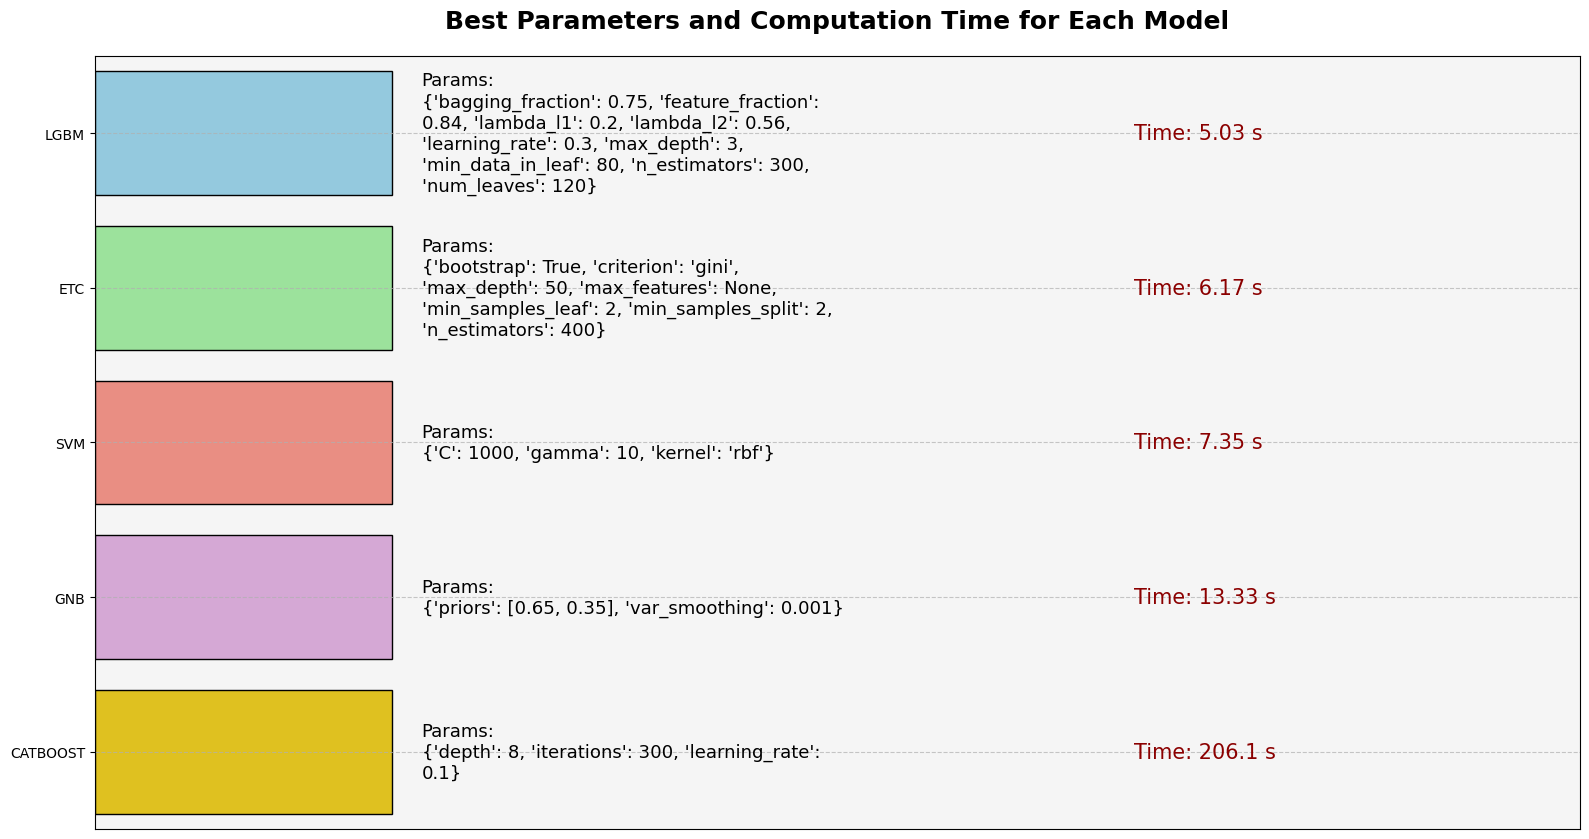

In [8]:
# Fungsi untuk memotong teks agar tidak terlalu panjang
def wrap_text(text, width=50):
    return "\n".join(textwrap.wrap(text, width))

# Ekstrak best parameters dan waktu komputasi untuk setiap model
model_names = []
best_params_list = []
computation_times_list = []

for name in grid_results.keys():
    model_names.append(name)
    best_params_list.append(wrap_text(str(grid_results[name].best_params_)))  # Potong teks agar lebih rapi
    computation_times_list.append(round(computation_times[name], 2))  # Ambil waktu komputasi

# Membuat DataFrame untuk mempermudah plotting
plot_data = pd.DataFrame({
    "Model": model_names,
    "Best Parameters": best_params_list,
    "Computation Time (s)": computation_times_list
})

# Warna untuk setiap model
colors = ["skyblue", "lightgreen", "salmon", "plum", "gold"][:len(model_names)]

# Plotting
plt.figure(figsize=(16, len(model_names) * 1.7))  # Sesuaikan tinggi plot berdasarkan jumlah model

# Gunakan `hue="Model"` dan `legend=False` untuk menghindari warning
sns.barplot(data=plot_data, y="Model", x=[1] * len(model_names), orient="h", palette=colors, edgecolor="black", hue="Model", legend=False)

# Menambahkan teks best parameters di sebelah kanan bar
for i, (model, params, time) in enumerate(zip(model_names, best_params_list, computation_times_list)):
    # Teks parameter
    plt.text(1.1, i, f"Params:\n{params}", va='center', fontsize=13, color='black', ha='left')

    # Teks waktu komputasi
    plt.text(3.5, i, f"Time: {time} s", va='center', fontsize=15, color='darkred', ha='left')

# Styling plot
plt.title("Best Parameters and Computation Time for Each Model", fontsize=18, pad=20, fontweight='bold')
plt.xlabel("")  # Hilangkan label sumbu X karena tidak relevan
plt.ylabel("")  # Hilangkan label sumbu Y karena sudah ada nama model
plt.xticks([])  # Menghilangkan sumbu X karena tidak relevan
plt.xlim(0, 5)  # Batasi sumbu X agar teks tidak terlalu jauh dari bar
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Tambahkan gridlines vertikal
plt.gca().set_facecolor('whitesmoke')  # Background abu-abu muda
plt.tight_layout()

# plt.savefig("../picture/Eval_Tuning_Params/BEST_PARAMS/computation_time.png", dpi=300, bbox_inches='tight')
# Menampilkan plot
plt.show()

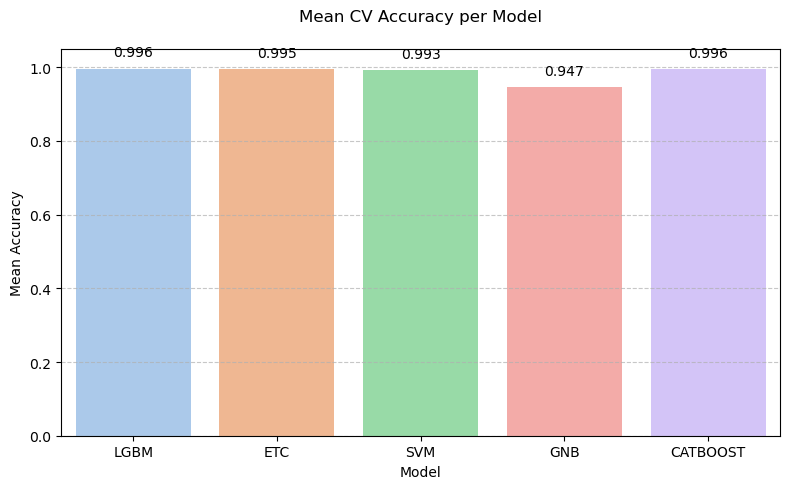

In [9]:
def plot_mean_cv_scores(cv_scores):
    mean_scores = {model: np.mean(scores) for model, scores in cv_scores.items()}
    df_scores = pd.DataFrame({
        "Model": list(mean_scores.keys()),
        "MeanAccuracy": list(mean_scores.values())
    })

    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_scores, x="Model", y="MeanAccuracy", palette="pastel", hue="Model", legend=False)

    plt.ylabel("Mean Accuracy")
    plt.title("Mean CV Accuracy per Model", pad=20)
    plt.ylim(0, 1.05)

    for i, row in df_scores.iterrows():
        plt.text(i, row["MeanAccuracy"] + 0.025, f"{row['MeanAccuracy']:.3f}", ha='center', va='bottom', fontsize=10)

    # plt.savefig("../picture/Eval_Tuning_Params/CV_SCORE/mean_cv_accuracy.png", dpi=300, bbox_inches='tight')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_mean_cv_scores(cv_scores)
